# Week 3:  Logistic Regression

## Data Analysis and Preprocessing

We will be using a toy dataset to examine how logistic regressions work.  The toy dataset will be the classic `wine` dataset, which we use for classification.  The dataset consists of 13 features, such as the amount of sulfur in the wine, that are used to determine the type of wine for the sample.  This dataset can be loaded directly in `sklearn`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from scipy.stats import describe
%matplotlib inline

In [2]:
wine = load_wine()

# Targets
X = wine.data
Y = wine.target

print(X.shape)
print(Y.shape)

(178, 13)
(178,)


We see that the dataset has 178 samples with 13 features.

Next we want to see what the distribution of targets looks like.  This is important because we want to ensure our classes are balanced.  To do this we use `numpy`'s `unique` function, which returns the unique values and their relative counts.

In [3]:
# Find the distribution of targets
counts = np.unique(Y, return_counts=True)
print(counts)

(array([0, 1, 2]), array([59, 71, 48]))


We see that there is a decent amount of imbalance between the most common and least common target.  Consequently, we need to rebalance the dataset.

Since the numbers are not extreme, we can use a standard `RandomOverSampler`.  If we were to see more extreme imbalance, we would likely need to interpolate the data using a more sophisticated technique like `SMOTE`.

In [4]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
sampler = RandomOverSampler(random_state=123)

# Balance the dataset
X, Y = sampler.fit_resample(X=X, y=Y)

print(X.shape)
print(Y.shape)

# Check to see if rebalanced
new_counts = np.unique(Y, return_counts=True)
print(new_counts)

(213, 13)
(213,)
(array([0, 1, 2]), array([71, 71, 71]))


Now that we have a good balance of samples, we can look at the statistics.

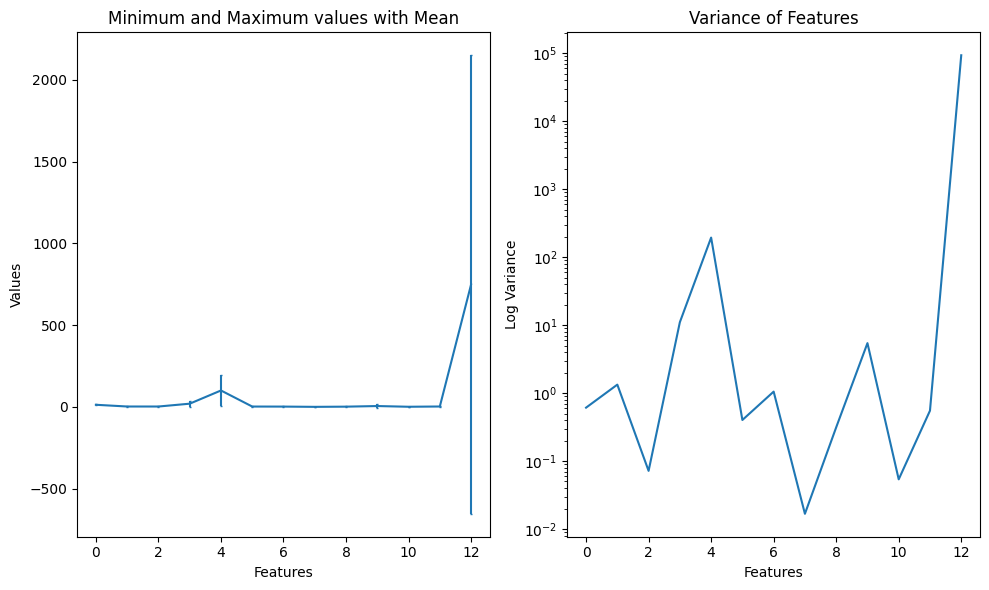

In [5]:
summary = describe(X)

# Compute Errors
features = np.arange(X.shape[1])
minmax_err = np.array([summary.minmax[1][i] - summary.minmax[0][i] for i in range(X.shape[1])])

# Plot statistics
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

axs[0].errorbar(features, summary.mean, yerr=minmax_err, capsize=0.5)
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Values')
axs[0].set_title('Minimum and Maximum values with Mean')
axs[1].plot(features, summary.variance)
axs[1].set_yscale('log')
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Log Variance')
axs[1].set_title('Variance of Features')
fig.tight_layout()
plt.show()

We see that plotting the error shows that the last feature has very high variance and a comparatively high mean.  We should examine this data more closely, so we plot it in a histogram:

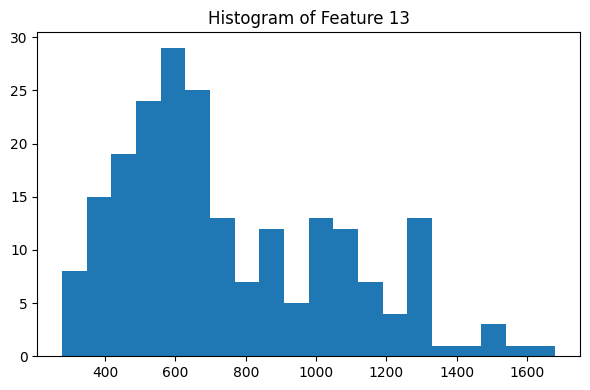

In [6]:
# Plot the histogram of the last feature
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(X[:,-1], bins=20)
ax.set_title('Histogram of Feature 13')
fig.tight_layout()

We see data here with extreme outliers.  This is a hint that we need to use `StandardScaler`.  We will go ahead and use that scaler to preprocess our data.

In [7]:
# Rescale the data
scaler = StandardScaler()
X_new = scaler.fit_transform(X=X)

## Model Training and Evaluation

We now split our data between training and test.  We will further split our training data for `KFold` cross-validation, with $10$ folds to evaluate model performance.

In [8]:
# Split the data between training and test data
indices = np.arange(X_new.shape[0])
X_tr, X_te, Y_tr, Y_te, idx_tr, idx_te = train_test_split(X_new, Y, indices, test_size=0.2, random_state=123)

# Initialize KFold
kf = KFold(n_splits=10)

First, we look at the performance of a `LogisticRegression` with no penalty, i.e. one that strictly minimizes the Cross-Entropy loss.

In [9]:
# Scores
scores = {'acc': [], 'auc': [], 'loss': []}

# Split the data
kfold = kf.split(X=X_tr, y=Y_tr)

for k, (train, test) in enumerate(kfold):
    # Initialize model
    clf_model = LogisticRegression(penalty=None)

    # Fit the model
    clf_model.fit(X=X_tr[train], y=Y_tr[train])

    # Predictions
    y_hats = clf_model.predict(X=X_tr[test])
    y_hats_probs = clf_model.predict_proba(X=X_tr[test])

    # Score the model
    acc = accuracy_score(y_true=Y_tr[test], y_pred=y_hats)
    auc = roc_auc_score(y_true=Y_tr[test], y_score=y_hats_probs, multi_class='ovo')
    loss = log_loss(y_true=Y_tr[test], y_pred=y_hats_probs)
    scores['acc'].append(acc)
    scores['auc'].append(auc)
    scores['loss'].append(loss)
    

    print(f'Fold: {k}, Accuracy: {acc}, AUC: {auc}, Loss: {loss}')

mean_acc = np.mean(scores['acc'])
std_acc = np.std(scores['acc'])
mean_auc = np.mean(scores['auc'])
std_auc = np.std(scores['auc'])
mean_loss = np.mean(scores['loss'])
std_loss = np.std(scores['loss'])

print(f'CV Accuracy: {mean_acc} +/- {std_acc}\nCV AUC: {mean_auc} +/- {std_auc}\nCV Loss: {mean_loss} +/- {std_loss}')

Fold: 0, Accuracy: 1.0, AUC: 1.0, Loss: 0.016976804459515476
Fold: 1, Accuracy: 1.0, AUC: 1.0, Loss: 1.601382838100678e-05
Fold: 2, Accuracy: 1.0, AUC: 1.0, Loss: 2.382646000481214e-08
Fold: 3, Accuracy: 1.0, AUC: 1.0, Loss: 3.0066059786007734e-06
Fold: 4, Accuracy: 1.0, AUC: 1.0, Loss: 0.00019406043613922564
Fold: 5, Accuracy: 1.0, AUC: 1.0, Loss: 5.007587763186039e-10
Fold: 6, Accuracy: 0.9411764705882353, AUC: 1.0, Loss: 0.476818703711314
Fold: 7, Accuracy: 1.0, AUC: 1.0, Loss: 0.00019922426436664095
Fold: 8, Accuracy: 0.9411764705882353, AUC: 1.0, Loss: 0.6556576146381881
Fold: 9, Accuracy: 0.8823529411764706, AUC: 1.0, Loss: 0.3414135904013411
CV Accuracy: 0.9764705882352942 +/- 0.03901911518065177
CV AUC: 1.0 +/- 0.0
CV Loss: 0.1491279042672443 +/- 0.23488362964374665


Very good performance on this dataset, though we see on at least 3 folds we did less than perfect. Now let's see how a model with the `L2` penalty, i.e. we penalize the model for higher weight values.

In [10]:
# Scores
scores = {'acc': [], 'auc': [], 'loss': []}

# Split the data
kfold = kf.split(X=X_tr, y=Y_tr)

for k, (train, test) in enumerate(kfold):
    # Initialize model
    clf_model = LogisticRegression(penalty='l2')

    # Fit the model
    clf_model.fit(X=X_tr[train], y=Y_tr[train])

    # Predictions
    y_hats = clf_model.predict(X=X_tr[test])
    y_hats_probs = clf_model.predict_proba(X=X_tr[test])

    # Score the model
    acc = accuracy_score(y_true=Y_tr[test], y_pred=y_hats)
    auc = roc_auc_score(y_true=Y_tr[test], y_score=y_hats_probs, multi_class='ovo')
    loss = log_loss(y_true=Y_tr[test], y_pred=y_hats_probs)
    scores['acc'].append(acc)
    scores['auc'].append(auc)
    scores['loss'].append(loss)
    

    print(f'Fold: {k}, Accuracy: {acc}, AUC: {auc}, Loss: {loss}')

mean_acc = np.mean(scores['acc'])
std_acc = np.std(scores['acc'])
mean_auc = np.mean(scores['auc'])
std_auc = np.std(scores['auc'])
mean_loss = np.mean(scores['loss'])
std_loss = np.std(scores['loss'])

print(f'CV Accuracy: {mean_acc} +/- {std_acc}\nCV AUC: {mean_auc} +/- {std_auc}\nCV Loss: {mean_loss} +/- {std_loss}')

Fold: 0, Accuracy: 1.0, AUC: 1.0, Loss: 0.06798774072629803
Fold: 1, Accuracy: 1.0, AUC: 1.0, Loss: 0.021594975514913677
Fold: 2, Accuracy: 1.0, AUC: 1.0, Loss: 0.0181174311007473
Fold: 3, Accuracy: 1.0, AUC: 1.0, Loss: 0.02897283477973835
Fold: 4, Accuracy: 1.0, AUC: 1.0, Loss: 0.0861661246829918
Fold: 5, Accuracy: 1.0, AUC: 1.0, Loss: 0.006989140408134014
Fold: 6, Accuracy: 1.0, AUC: 1.0, Loss: 0.100344043280058
Fold: 7, Accuracy: 1.0, AUC: 1.0, Loss: 0.03706134671335396
Fold: 8, Accuracy: 0.9411764705882353, AUC: 1.0, Loss: 0.13184780109752953
Fold: 9, Accuracy: 0.8823529411764706, AUC: 1.0, Loss: 0.1995571093651968
CV Accuracy: 0.9823529411764707 +/- 0.03766543669078147
CV AUC: 1.0 +/- 0.0
CV Loss: 0.06986385476689615 +/- 0.057939246123413383


We have both better accuracy and lower loss here.  Looking at our folds, we also perform better on the folds.  Now, let's train the full models and see how they do on our hold-out test set.

In [12]:
# Initialize both models
clf_none_model = LogisticRegression(penalty=None)
clf_l2_model = LogisticRegression(penalty='l2')

# Train the models on the whole data
clf_none_model.fit(X=X_tr, y=Y_tr)
clf_l2_model.fit(X=X_tr, y=Y_tr)

# Evaluate the models on the test data
for i, model in enumerate([clf_none_model, clf_l2_model]):
    # Get predictions
    y_hats = model.predict(X=X_te)
    y_hats_probs = model.predict_proba(X=X_te)

    # Score the models
    acc = accuracy_score(y_true=Y_te, y_pred=y_hats)
    auc = roc_auc_score(y_true=Y_te, y_score=y_hats_probs, multi_class='ovo')
    loss = log_loss(y_true=Y_te, y_pred=y_hats_probs)

    # Print the results
    print(f'Model {i} has test metrics of:\nAccuracy: {acc}\nAUC: {auc}\nLoss: {loss}')

Model 0 has test metrics of:
Accuracy: 1.0
AUC: 1.0
Loss: 3.0490764579406527e-06
Model 1 has test metrics of:
Accuracy: 1.0
AUC: 1.0
Loss: 0.018336784925017335


Both models did perfectly no the test data.